This notebook demonstrates the use of [**Techtonique**](https://github.com/Techtonique)'s Python packages for **Statistical/Machine Learning**. 

**Contents**

- 0 - Import-packages
- 1 - Data-wrangling (using the `querier`)
- 2 - Modeling/Hyperparameter tuning (using the `mlsauce` and `GPopt`)
- 3 - Explain model's decisions (using `the-teller`)

# 0 - Import packages 

In [ ]:
!pip install querier # A query language for Python Data Frames (part of Techtonique)

In [ ]:
!pip install mlsauce # Miscellaneous Statistical/Machine Learning stuff (part of Techtonique)

In [ ]:
!pip install GPopt # Bayesian optimization using Gaussian Process Regression (part of Techtonique)

In [ ]:
!pip install the-teller # Model-agnostic Statistical/Machine Learning explainability (part of Techtonique)

In [ ]:
! pip install scikit-learn

In [ ]:
!pip install SQLAlchemy

In [ ]:
!pip install matplotlib==3.1.3 # required for explainer's graphs

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
import sqlalchemy
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.metrics import classification_report, confusion_matrix
from time import time

import querier as qr 
import GPopt as gp 
import mlsauce as ms
import teller as tr 

# 1 - Data-wrangling (using the `querier`)


**tested on macOS, Linux so far/experimental**

In [ ]:
breast_cancer = load_breast_cancer(as_frame=True)

In [ ]:
print(breast_cancer.DESCR)

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [ ]:
breast_cancer_df = breast_cancer.frame

In [ ]:
breast_cancer_df_columns = breast_cancer_df.columns

In [ ]:
breast_cancer_df.columns = ["_".join(elt.split()) for elt in breast_cancer_df_columns]

In [ ]:
breast_cancer_df

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [ ]:
qr.select(breast_cancer_df, "mean_radius, mean_texture, mean_perimeter, mean_area, target", 
          limit=4, random=True)

,mean_radius,mean_texture,mean_perimeter,mean_area,target
256,19.55,28.77,133.60,1207.0,0
342,11.06,14.96,71.49,373.9,1
313,11.54,10.72,73.73,409.1,1
477,13.90,16.62,88.97,599.4,1


In [ ]:
qr.filtr(breast_cancer_df, "(target == 1) & (mean_radius >= 10)")

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,...,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target
19,13.54,14.36,87.46,566.3,0.09779,0.08129,0.066640,0.04781,0.1885,0.05766,...,19.26,99.70,711.2,0.14400,0.17730,0.23900,0.12880,0.2977,0.07259,1
20,13.08,15.71,85.63,520.0,0.10750,0.12700,0.045680,0.03110,0.1967,0.06811,...,20.49,96.09,630.5,0.13120,0.27760,0.18900,0.07283,0.3184,0.08183,1
37,13.03,18.42,82.61,523.8,0.08983,0.03766,0.025620,0.02923,0.1467,0.05863,...,22.81,84.46,545.9,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169,1
48,12.05,14.63,78.04,449.3,0.10310,0.09092,0.065920,0.02749,0.1675,0.06043,...,20.70,89.88,582.6,0.14940,0.21560,0.30500,0.06548,0.2747,0.08301,1
49,13.49,22.30,86.91,561.0,0.08752,0.07698,0.047510,0.03384,0.1809,0.05718,...,31.82,99.00,698.8,0.11620,0.17110,0.22820,0.12820,0.2871,0.06917,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,10.16,19.59,64.73,311.7,0.10030,0.07504,0.005025,0.01116,0.1791,0.06331,...,22.88,67.88,347.3,0.12650,0.12000,0.01005,0.02232,0.2262,0.06742,1
558,14.59,22.68,96.39,657.1,0.08473,0.13300,0.102900,0.03736,0.1454,0.06147,...,27.27,105.90,733.5,0.10260,0.31710,0.36620,0.11050,0.2258,0.08004,1
559,11.51,23.93,74.52,403.5,0.09261,0.10210,0.111200,0.04105,0.1388,0.06570,...,37.16,82.28,474.2,0.12980,0.25170,0.36300,0.09653,0.2112,0.08732,1
560,14.05,27.15,91.38,600.4,0.09929,0.11260,0.044620,0.04304,0.1537,0.06171,...,33.17,100.20,706.7,0.12410,0.22640,0.13260,0.10480,0.2250,0.08321,1


In [ ]:
breast_cancer_df['target'] = breast_cancer_df['target'].astype(object)

In [ ]:
qrobj = qr.Querier(df=breast_cancer_df)

request_1 = qrobj.select("mean_radius,\
                          mean_concave_points,\
                          target")\
                 .summarize("avg(mean_radius),\
                             avg(mean_concave_points),\
                             target", 
                            group_by = "target")            
print(request_1.get_df())

   avg_mean_radius  avg_mean_concave_points  target
0        17.462830                 0.087990       0
1        12.146524                 0.025717       1


# 2 - Modeling/Hyperparameter tuning (using the `mlsauce` and `GPopt`)

In [ ]:
X = breast_cancer.data
y = breast_cancer.target
# split data into training test and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.2, random_state=123)

In [ ]:
def lsboost_cv(X_train, y_train, 
               n_estimators=100,  
               learning_rate=0.1, 
               n_hidden_features=5, 
               reg_lambda=0.1, 
               row_sample=0.9,
               col_sample=0.9,               
               dropout=0, 
               tolerance=1e-4,                 
               seed=123):                
    
    estimator = ms.LSBoostClassifier(n_estimators=n_estimators, 
                                     activation="relu",
                                     learning_rate=learning_rate,
                                     n_hidden_features=n_hidden_features, 
                                     reg_lambda=reg_lambda,
                                     row_sample=row_sample, 
                                     col_sample=col_sample,
                                     dropout=dropout,
                                     tolerance=tolerance,
                                     seed=seed, verbose=0)

    cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=123)
    
    return -cross_val_score(estimator, X_train, y_train,
                          scoring='accuracy', cv=cv, n_jobs=4).mean()    

In [ ]:
def optimize_lsboost(X_train, y_train):

    def crossval_objective(x):
        
        return lsboost_cv(            
          X_train=X_train, 
          y_train=y_train,
          n_estimators=int(x[0]),  
          learning_rate=10**x[1],
          n_hidden_features=int(x[2]), 
          reg_lambda=10**x[3], 
          col_sample=x[4], 
          row_sample=x[5], 
          dropout=x[6],        
          tolerance=10**x[7])
    
    gp_opt = gp.GPOpt(objective_func=crossval_objective, 
                      lower_bound = np.array([  50, -6,   2, -2, 0.5, 0.5,   0, -6]), 
                      upper_bound = np.array([1000, -1, 250,  5,   1,   1, 0.7, -1]),
                      n_init=10, n_iter=90, seed=123)    
    #return {'parameters': gp_opt.optimize(verbose=2, abs_tol=1e-4), 'opt_object':  gp_opt}
    return {'parameters': gp_opt.optimize(verbose=2), 'opt_object':  gp_opt}


In [ ]:
res_optimize_lsboost = optimize_lsboost(X_train, y_train)


 Creating initial design... 

point: [ 5.25e+02 -3.50e+00  1.26e+02  1.50e+00  7.50e-01  7.50e-01  3.50e-01
 -3.50e+00]; score: -0.6930402930402929
point: [ 7.625e+02 -4.750e+00  1.880e+02 -2.500e-01  8.750e-01  6.250e-01
  5.250e-01 -4.750e+00]; score: -0.6263736263736263
point: [ 2.875e+02 -2.250e+00  6.400e+01  3.250e+00  6.250e-01  8.750e-01
  1.750e-01 -2.250e+00]; score: -0.8871794871794874
point: [ 4.0625e+02 -4.1250e+00  1.5700e+02 -1.1250e+00  9.3750e-01  9.3750e-01
  8.7500e-02 -2.8750e+00]; score: -0.6263736263736263
point: [ 8.8125e+02 -1.6250e+00  3.3000e+01  2.3750e+00  6.8750e-01  6.8750e-01
  4.3750e-01 -5.3750e+00]; score: -0.701098901098901
point: [ 6.4375e+02 -5.3750e+00  9.5000e+01  6.2500e-01  5.6250e-01  8.1250e-01
  6.1250e-01 -1.6250e+00]; score: -0.6263736263736263
point: [168.75    -2.875  219.       4.125    0.8125   0.5625   0.2625  -4.125 ]; score: -0.6549450549450548
point: [ 2.28125e+02 -4.43750e+00  7.95000e+01  2.81250e+00  7.81250e-01
  5.93750e-01  4

In [ ]:
res_optimize_lsboost 

{'opt_object': <GPopt.GPOpt.GPOpt.GPOpt at 0x7f153309e9d0>,
 'parameters': (array([ 8.79365540e+02, -1.63491821e+00,  4.09089355e+01,  3.06137085e+00,
          7.37228394e-01,  7.63473511e-01,  1.38833618e-01, -4.65249634e+00]),
  -0.9531135531135532)}

In [ ]:
best_parameters = res_optimize_lsboost['parameters'][0]

In [ ]:
start = time()

estimator_breast_cancer = ms.LSBoostClassifier(n_estimators=int(best_parameters[0]),  
                                               learning_rate=10**best_parameters[1],
                                               n_hidden_features=int(best_parameters[2]), 
                                               reg_lambda=10**best_parameters[3], 
                                               col_sample=best_parameters[4], 
                                               row_sample=best_parameters[5], 
                                               dropout=best_parameters[6],        
                                               tolerance=10**best_parameters[7],
                                               seed=123, verbose=0).fit(X_train, y_train)

print(f"\n\n Test set accuracy: {estimator_breast_cancer.score(X_test, y_test)}")
print(f"\n Elapsed: {time() - start}")



 Test set accuracy: 0.9824561403508771

 Elapsed: 3.462388038635254


In [ ]:
y_pred = estimator_breast_cancer.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98        42
           1       0.97      1.00      0.99        72

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



In [ ]:
print(confusion_matrix(y_test, y_pred))

[[40  2]
 [ 0 72]]


# 3 - Explain model's decisions (using `the-teller`)

In [ ]:
# creating the explainer for class = 1 (probability of being a malignant tumor)
expr = tr.Explainer(obj=estimator_breast_cancer, y_class=1, normalize=False) 

In [ ]:
# adjusting the explainer to the test set
expr.fit(X_test.values, y_test.values, X_names=list(breast_cancer.feature_names))



Calculating the effects...
30/30 [██████████████████████████████] - 3s 86ms/step




Explainer(obj=LSBoostClassifier(col_sample=0.7372283935546875,
                                dropout=0.13883361816406248,
                                learning_rate=0.023178311069471363,
                                n_estimators=385, n_hidden_features=40,
                                reg_lambda=1151.7834917887246,
                                row_sample=0.7634735107421875,
                                tolerance=2.2258898141256302e-05, verbose=0),
          y_class=1)

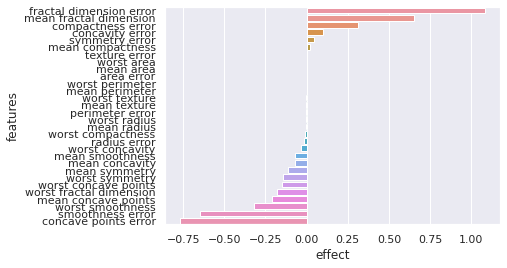

In [ ]:
# summary of results for the model (must use matplotlib=3.1.3)
expr.plot(what="average_effects")

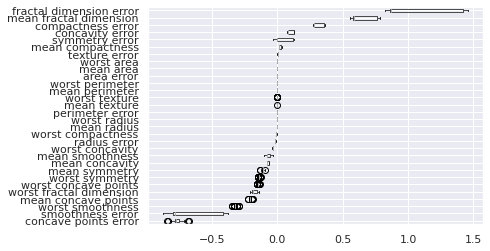

In [ ]:
# Heterogeneity of effects (must use matplotlib=3.1.3)
expr.plot(what="hetero_effects")

In [ ]:
# summary of results for the model
print(expr.summary())



Heterogeneity of marginal effects: 
                             mean       std    median       min       max
fractal dimension error  1.082723  0.266851  0.868091  0.819966  1.456801
mean fractal dimension   0.652445  0.087281  0.586653  0.556320  0.782740
compactness error        0.310099  0.035665  0.283370  0.269509  0.360864
concavity error          0.097867  0.023285  0.079271  0.071594  0.129780
symmetry error           0.047409  0.058531 -0.000141 -0.031695  0.128003
mean compactness         0.021578  0.007013  0.016079  0.011121  0.032218
texture error            0.001695  0.000844  0.001001  0.000533  0.002907
worst area              -0.000008  0.000001 -0.000009 -0.000010 -0.000006
mean area               -0.000012  0.000002 -0.000013 -0.000014 -0.000009
area error              -0.000015  0.000016 -0.000027 -0.000032  0.000007
worst perimeter         -0.000197  0.000016 -0.000206 -0.000222 -0.000162
mean perimeter          -0.000231  0.000019 -0.000243 -0.000261 -0.000191
